## Kate Groschner
## AY250 Homework 3

# 1) Monty: The Python Siri

Let's make a Siri-like program (call it Monty!) with the following properties:
   - record your voice command
   - use a webservice to parse that sound file into text
   - based on what the text, take three different types of actions:
       - send an email to yourself
       - do some math
       - tell a joke

So for example, if you say "Monty: email me with subject hello and body goodbye", it will email you with the appropriate subject and body. If you say "Monty: tell me a joke" then it will go to the web and find a joke and print it for you. If you say, "Monty: calculate two times three" it should response with printing the number 6.

Hint: you can use speed-to-text apps like Houndify (or, e.g., Google Speech https://cloud.google.com/speech/) to return the text (but not do the actions). You'll need to sign up for a free API and then follow documentation instructions for using the service within Python. 

# Question 1
My strategy for this question is to use the audio recording script Prof. Bloom showed in class. Send this to a houndify to parse, this portion was written mostly using the documentation provided by houndify. Taking the output text from houndify is put into a list format after determining the type of request. This part of the script is essentially a decision tree that leads to the last step that either a) uses stmp to send an email or b) does the math, or finally c) uses beautifulsoup to go to a website and get jokes

The math portion can take in directions in several ways:
    addition can either be directed as "number plus number" or "add number and number"
    subtraction can be "number minus number" or "subtract number from number"
    multiplication can be "number times number" or "multiply number and number"
    division is given as "number divided by number"

The email segment requires the following verbal format:
    "email me subject FILL IN and body FILL IN"
    As long as you say email before any other command including joke, add, times etc. the program will email you and 
    not follow the later command
    
The joke segment only requires that you say "joke" and do not activate any of the other functionalities 

    

In [1]:
#Audio recording portion taken from lecture notes and cross referenced with the PyAudio example documentation
import pyaudio 
import wave

def ask_monty():
    """This function records 16 bit audio that is saved as a file called ask_monty.wav which is can then be fed
    into the audio2text file"""
    chunk = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 16000
    RECORD_SECONDS = 10
    WAVE_OUTPUT_FILENAME = "ask_monty.wav"
    p = pyaudio.PyAudio()
    stream = p.open(format = FORMAT,
        channels = CHANNELS,
        rate = RATE,
        input = True,
        frames_per_buffer = chunk)
    print("* recording")
    frames = []
    for i in range(0, int(RATE / chunk * RECORD_SECONDS)):
        data = stream.read(chunk)
        frames.append(data)
    print("* done recording")
    stream.close()
    p.terminate()

    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()

In [2]:
#define a function to do the speech to text inquiry
import houndify
import wave
import time
import my_credentials as mc

class MyListener(houndify.HoundListener):
  def onFinalResponse(self, response):
    print("Final response: " + str(response))
  def onError(self, err):
    print("Error: " + str(err))


def audio2text():
    """ This function sends the ask_monty.wav file generated by ask_monty() to houndify where is parsed and returns
    JSON data. It requires that you have a file labelled my_credentials.py with houndify credentials labelled CLIENT_ID
    and CLIENT_KEY"""
    AUDIO_FILE = "ask_monty.wav"
    BUFFER_SIZE = 512
    client = houndify.StreamingHoundClient(mc.CLIENT_ID, mc.CLIENT_KEY, "test_user")
    audio = wave.open(AUDIO_FILE)
    if audio.getsampwidth() != 2:
      print("%s: wrong sample width (must be 16-bit)" % AUDIO_FILE)
    if audio.getframerate() != 8000 and audio.getframerate() != 16000:
      print("%s: unsupported sampling frequency (must be either 8 or 16 khz)" % AUDIO_FILE)
    if audio.getnchannels() != 1:
      print("%s: must be single channel (mono)" % AUDIO_FILE)

    client.setSampleRate(audio.getframerate())
    client.start(MyListener())

    while True:
      samples = audio.readframes(BUFFER_SIZE)
      if len(samples) == 0: break
      if client.fill(samples): break


    result = client.finish() # returns either final response or error
    return result


In [3]:
#defining a function to classify the output of houndify
def sntc_type(result):
    """This function takes in the result returned from houndify and will return a list of the words in that text \
    and a classification of whether asking for math, email, or joke"""
    sentence = result['AllResults'][0]['FormattedTranscription']
    print('\n', 'Your inquiry is: ',sentence)
    if 'email' in sentence:
        sntcType = ('email','email')
    elif 'plus' in sentence:
        sntcType = ('math','addition')
    elif 'add' in sentence:
        sntcType = ('math','addition')
    elif 'time' in sentence:
        sntcType = ('math','multiplication')
    elif 'multiply' in sentence:
        sntcType = ('math','multiplication')
    elif 'minus' in sentence:
        sntcType = ('math','subtraction')
    elif 'subtract' in sentence:
        sntcType = ('math','subtraction')
    elif 'divided' in sentence:
        sntcType = ('math','division')
    elif 'joke' in sentence:
        sntcType = ('joke','joke')
    else:
        print('Inquiry not of valid type. Please record your question again.')
        sntcType = 'Invalid'
    sntcList = sentence.split(" ")
    return sntcType, sntcList


In [4]:
#defining functions to send email. Note that originally I had mailServer.starttls() in the code 
# however I kept getting the error SMTPNotSupportedError: STARTTLS extension not supported by server.
#Once I removed that line it started working again
import smtplib
import os
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email.mime.text import MIMEText
from email import encoders
from email.utils import COMMASPACE, formatdate
import my_credentials as mc

def mail(subject, text):
    msg = MIMEMultipart()
    msg["From"] = mc.GMAIL_USERNAME
    msg["To"] = COMMASPACE.join(mc.GMAIL_USERNAME)
    msg["Date"] = formatdate(localtime=True)
    msg["Subject"] = subject
    msg.attach(MIMEText(text))
    mailServer = smtplib.SMTP_SSL('smtp.gmail.com', 465)
#     mailServer.starttls()
    mailServer.login(mc.GMAIL_USERNAME, mc.GMAIL_PASSWORD)
    mailServer.sendmail(mc.GMAIL_USERNAME, mc.GMAIL_USERNAME, msg.as_string())
    mailServer.close()

def monty_mail(sntcList):
    idx_sub = sntcList.index('subject')
    idx_bod = sntcList.index('body')
    subject = ' '.join(sntcList[idx_sub+1:idx_bod])
    text = ' '.join(sntcList[idx_bod+1:])
    mail(subject,text)
    print('Email sent.')
    

In [5]:
#Here I define output math functions to call to handle requests to do math. 
#There is one monty_math function which decides which math function to call
#use the try except statements to deal with decimal place responses which give strings of ints instead of words
#which makes word2number fail
from word2number import w2n

def monty_add(listIn):
    if 'plus' in listIn:
        idx = listIn.index('plus')
        try:
            answer = w2n.word_to_num(listIn[idx-1]) + w2n.word_to_num(listIn[idx+1])
        except:
            answer = float(listIn[idx-1]) + float(listIn[idx+1])
    elif 'add' in listIn:
        idx = listIn.index('add')
        try:
            answer = w2n.word_to_num(listIn[idx+1]) + w2n.word_to_num(listIn[idx+3])
        except:
            answer = float(listIn[idx+1]) + float(listIn[idx+3])
    print('\n')
    print('The answer is {}'.format(answer))
    return answer

def monty_subtract(listIn):
    if 'minus' in listIn:
        idx = listIn.index('minus')
        try:
            answer = w2n.word_to_num(listIn[idx-1]) - w2n.word_to_num(listIn[idx+1])
        except:
            answer = float(listIn[idx-1]) - float(listIn[idx+1])
    elif 'subtract' in listIn:
        idx = listIn.index('subtract')
        try:
            answer = w2n.word_to_num(listIn[idx+3]) - w2n.word_to_num(listIn[idx+1])
        except:
            answer = float(listIn[idx+3]) - float(listIn[idx+1])
    print('\n')
    print('The answer is {}'.format(answer))
    return answer
      
def monty_multiply(listIn):
    if 'times' in listIn:
        idx = listIn.index('times')
        try:
            answer = w2n.word_to_num(listIn[idx-1]) * w2n.word_to_num(listIn[idx+1])
        except:
            answer = float(listIn[idx-1]) * float(listIn[idx+1])
    elif 'multiply' in listIn:
        idx = listIn.index('subtract')
        try:
            answer = w2n.word_to_num(listIn[idx+1]) * w2n.word_to_num(listIn[idx+3])
        except:
            answer = float(listIn[idx+1]) * float(listIn[idx+3])
    print('\n')
    print('The answer is {}'.format(answer))
    return answer

def monty_divide(listIn):
    if 'divided' in listIn:
        idx = listIn.index('divided')
        try:
            answer = w2n.word_to_num(listIn[idx-1]) / w2n.word_to_num(listIn[idx+2])
        except:
            answer = float(listIn[idx-1]) / float(listIn[idx+2])
    print('\n')
    print('The answer is {}'.format(answer))
    return answer

def monty_math(sntcType,sntcList):
    if sntcType == 'addition':
        monty_add(sntcList)
    elif sntcType == 'multiplication':
        monty_multiply(sntcList)
    elif sntcType == 'subtraction':
        monty_subtract(sntcList)
    elif sntcType == 'division':
        monty_divide(sntcList)
    else:
        print('\n','Invalid call to monty_math')
    

In [6]:
#Output function to get dad jokes from a website and then print that joke
def monty_joke():
    from urllib.request import urlopen
    from bs4 import BeautifulSoup
    import json
    from random import randint
    jk_url = 'http://pun.me/pages/dad-jokes.php'
    response = urlopen(jk_url)
    jk = response.read().decode('-utf-8')
    response.close()
    jk_soup = BeautifulSoup(jk,"html.parser")
    items = jk_soup.findAll("li")
    #now that I have a list of all the content items from the page I want to strip the html off
    #and the items that are buttons to other pages and just have strings
    jokes  = [i.text.strip() for i in items if "<a href=" not in str(i)]
    idx = randint(0,39)
    print('\n',jokes[idx])


In [7]:
#Finally define a function called Monty which will call all the sub functions and handle which output function to call
def monty():
    ask_monty()
    result = audio2text()
    sntcType, sntcList = sntc_type(result)
    if sntcType == 'Invalid':
        print('\n','Sorry Monty failed you. Please try again.')
    elif sntcType[0] == 'email':
        monty_mail(sntcList)
    elif sntcType[0] == 'math':
        monty_math(sntcType[1],sntcList)
    elif sntcType[0] == 'joke':
        monty_joke()
    else:
        print('\n','Sorry Monty failed you. Please try again.')

In [8]:
monty()

* recording
* done recording
Final response: {'Format': 'SoundHoundVoiceSearchResult', 'FormatVersion': '1.0', 'Status': 'OK', 'NumToReturn': 1, 'AllResults': [{'CommandKind': 'SpeechToTextOnlyCommand', 'SpokenResponse': 'manti tell me a joke', 'SpokenResponseLong': 'manti tell me a joke', 'WrittenResponse': 'Manti tell me a joke', 'WrittenResponseLong': 'Manti tell me a joke', 'AutoListen': False, 'ViewType': ['Native', 'None'], 'RawTranscription': 'manti tell me a joke', 'FormattedTranscription': 'Manti tell me a joke', 'NativeData': {'RawTranscription': 'manti tell me a joke', 'FormattedTranscription': 'Manti tell me a joke'}}], 'Disambiguation': {'NumToShow': 1, 'ChoiceData': [{'Transcription': 'manti tell me a joke', 'ConfidenceScore': 1, 'FixedTranscription': 'manti tell me a joke'}]}, 'ResultsAreFinal': [True], 'DomainUsage': [{'Domain': 'Speech To Text Only', 'DomainUniqueID': '3224afd8-821b-4e3e-b206-d92d160048cb', 'CreditsUsed': 0}], 'BuildInfo': {'User': 'knightly', 'Date': 

# 2) Write a program that identifies musical notes from sound (AIFF) files. 

  - Run it on the supplied sound files (12) and report your program’s results. 
  - Use the labeled sounds (4) to make sure it works correctly. The provided sound files contain 1-3 simultaneous notes from different organs.
  - Save copies of any example plots to illustrate how your program works.
  
  https://piazza.com/berkeley/spring2018/ay250class13410/resources -> Homeworks -> hw3_sound_files.zip

Hints: You’ll want to decompose the sound into a frequency power spectrum. Use a Fast Fourier Transform. Be care about “unpacking” the string hexcode into python data structures. The sound files use 32 bit data. Play around with what happens when you convert the string data to other integer sizes, or signed vs unsigned integers. Also, beware of harmonics.

In [157]:
%matplotlib inline
import os
import aifc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



def aiff_convert(sdir,dt='int32'):
    """A function to loop through the directory of aif files,
    open them, and convert them to numpy arrays"""
    files = os.listdir(sdir)
    files = [x for x in files if 'aif' in x]
    rate_list = []
    data = []
    length =[]
    filenames = []
    for fname in files:
        file = aifc.open(sdir+'/'+fname)
        nframes = file.getnframes()
        str_data = file.readframes(nframes)
        np_data = np.frombuffer(str_data, dtype=dt).byteswap()
        length.append(len(np_data))
        rate = file.getframerate()
        rate_list.append(rate)
        data.append(np_data)
        filenames.append(fname)
    return length, rate_list, data,filenames

In [158]:
length, rate_list, data, filenames = aiff_convert('sound_files', dt = 'uint32')

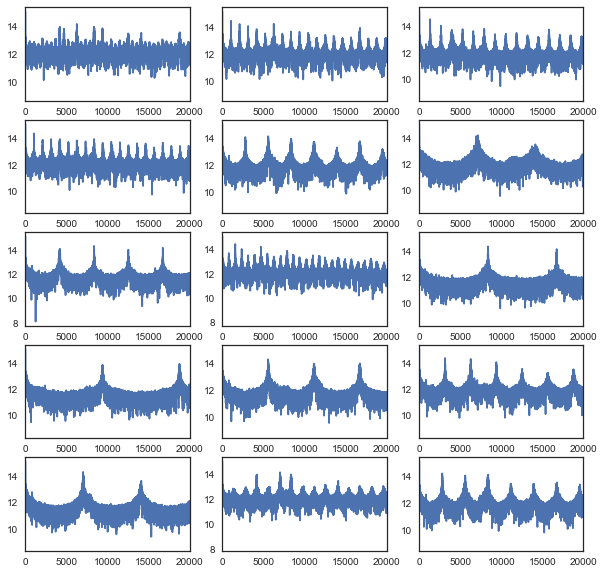

In [159]:
f = plt.figure(figsize=(10,10))

ax1 = plt.subplot2grid((5, 3), (0, 0))
ax2 = plt.subplot2grid((5, 3), (0, 1))
ax3 = plt.subplot2grid((5, 3), (0, 2))
ax4 = plt.subplot2grid((5, 3), (1, 0))
ax5 = plt.subplot2grid((5, 3), (1, 1))
ax6 = plt.subplot2grid((5, 3), (1, 2))
ax7 = plt.subplot2grid((5, 3), (2, 0))
ax8 = plt.subplot2grid((5, 3), (2, 1))
ax9 = plt.subplot2grid((5, 3), (2, 2))
ax10 = plt.subplot2grid((5, 3), (3, 0))
ax11 = plt.subplot2grid((5, 3), (3, 1))
ax12 = plt.subplot2grid((5, 3), (3, 2))
ax13 = plt.subplot2grid((5, 3), (4, 0))
ax14 = plt.subplot2grid((5, 3), (4, 1))
ax15 = plt.subplot2grid((5, 3), (4, 2))

axes_list = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15]


for idx,ax in enumerate(axes_list):
#     ax.plot(np.fft.fftfreq(length[idx]),np.fft.fft(data[idx]))
#     ax.set_xlim(-0.25,0.25)
    ax.plot(np.log10(np.abs(np.fft.fft(data[idx]))))
    ax.set_xlim(0,20000)

In [160]:
def get_notes():
    from urllib.request import urlopen
    from bs4 import BeautifulSoup
    import json
    url = 'https://pages.mtu.edu/~suits/notefreqs.html'
    response = urlopen(url)
    note_response = response.read().decode('-utf-8')
    response.close()
    note_soup = BeautifulSoup(note_response,"html.parser")
    items = note_soup.findAll("table" and "td")
    notes  = [i.text.strip() for i in items if "<a href=" not in str(i)]
    notes = np.asarray(notes[1:]).reshape(108,3)
    return notes

In [178]:
known_note_frequencies = get_notes()[:][:,1].tolist()
note_names = get_notes()[:][:,0]
note_freq = [int(round(float(x))) for x in known_note_frequencies]
note_freq

[16,
 17,
 18,
 19,
 21,
 22,
 23,
 24,
 26,
 28,
 29,
 31,
 33,
 35,
 37,
 39,
 41,
 44,
 46,
 49,
 52,
 55,
 58,
 62,
 65,
 69,
 73,
 78,
 82,
 87,
 92,
 98,
 104,
 110,
 117,
 123,
 131,
 139,
 147,
 156,
 165,
 175,
 185,
 196,
 208,
 220,
 233,
 247,
 262,
 277,
 294,
 311,
 330,
 349,
 370,
 392,
 415,
 440,
 466,
 494,
 523,
 554,
 587,
 622,
 659,
 698,
 740,
 784,
 831,
 880,
 932,
 988,
 1046,
 1109,
 1175,
 1245,
 1319,
 1397,
 1480,
 1568,
 1661,
 1760,
 1865,
 1976,
 2093,
 2217,
 2349,
 2489,
 2637,
 2794,
 2960,
 3136,
 3322,
 3520,
 3729,
 3951,
 4186,
 4435,
 4699,
 4978,
 5274,
 5588,
 5920,
 6272,
 6645,
 7040,
 7459,
 7902]

In [180]:
max_list = [np.argmax(np.log10(np.abs(np.fft.fft(x[1000:])))) for x in data]
max_list

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [181]:
def find_match(data):
    unknown_max_list = [np.argmax(np.abs(np.fft.rfft(x))) for x in data]
    notes = get_notes()
    for unknown in unknown_max_list:
        for note in notes[:,3]:
            idx_match = (np.abs(unknown-note[])).argmin()

SyntaxError: invalid syntax (<ipython-input-181-0bc8fea1d4ab>, line 6)